# Trend Analysis of Carbon and Water Fluxes in AusEFlux

Trend analysis - include trends on lower and upper percentiles

Changes in seasonality of Australia’s NEE cycle – Aus-wide phenology curve for 1987-2002; 2002-2022…has there been a shift?

* Does that shift match a shift in the NDVI phenology? What about a CO2 phenology curve from one of the research stations (not Tassie though)
* Seasonality isolines? Shifting LOS, SOS, EOS?



In [1]:
import sys
import folium
import warnings
import xarray as xr
import pandas as pd
import seaborn as sb
import geopandas as gpd
import xarray as xr
import numpy as np
import contextily as ctx

import matplotlib.pyplot as plt

import odc.geo.xr
from odc.geo.geobox import zoom_out
from odc.geo.xr import assign_crs
# from odc.geo.xr import rasterize

sys.path.append('/g/data/os22/chad_tmp/NEE_modelling/')
from _collect_prediction_data import round_coords

sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/')
from dea_tools.spatial import xr_rasterize

In [ ]:
# sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
# from dask_utils import start_local_dask

# client = start_local_dask(mem_safety_margin='2Gb')
# client

## Analysis Parameters

Start with 5km resolution datasets to speed up exploration

In [2]:
er_path = '/g/data/os22/chad_tmp/NEE_modelling/results/predictions/AusEFlux_ER_2003_2022_5km_quantiles_v1.1.nc'
gpp_path = '/g/data/os22/chad_tmp/NEE_modelling/results/predictions/AusEFlux_GPP_2003_2022_5km_quantiles_v1.1.nc'
nee_path = '/g/data/os22/chad_tmp/NEE_modelling/results/predictions/AusEFlux_NEE_2003_2022_5km_quantiles_v1.1.nc'
et_path = '/g/data/os22/chad_tmp/NEE_modelling/results/predictions/AusEFlux_ET_2003_2022_5km_quantiles_v1.1.nc'
ndvi_path = '/g/data/os22/chad_tmp/NEE_modelling/data/1km/kNDVI_1km_monthly_2002_2022.nc'

chunks=None#dict(latitude=250, longitude=250, time=1)

t_range='2003', '2021'

#SE AUS
# lat_bounds = slice(355, 590)
# lon_bounds = slice(575,840)

#All of Aus
lat_bounds = slice(0, 680)
lon_bounds = slice(0,840)

## Open data

And clip to lat/lon bounds

In [3]:
er = assign_crs(xr.open_dataset(er_path, chunks=chunks)['ER_median'].isel(latitude=lat_bounds, longitude=lon_bounds), crs='EPSG:4326')
gpp = assign_crs(xr.open_dataset(gpp_path, chunks=chunks)['GPP_median'].isel(latitude=lat_bounds, longitude=lon_bounds),  crs='EPSG:4326')
nee = assign_crs(xr.open_dataset(nee_path, chunks=chunks)['NEE_median'].isel(latitude=lat_bounds, longitude=lon_bounds),  crs='EPSG:4326')
et = assign_crs(xr.open_dataset(et_path, chunks=chunks)['ET_median'].isel(latitude=lat_bounds, longitude=lon_bounds),  crs='EPSG:4326')

er =  round_coords(er)
gpp =  round_coords(gpp)
nee =  round_coords(nee)
et =  round_coords(et)

In [4]:
ndvi = assign_crs(xr.open_dataset(ndvi_path, chunks=chunks)['kNDVI'], crs='EPSG:4326')
ndvi = ndvi.odc.reproject(et.odc.geobox, resampling='average')
ndvi = ndvi.isel(latitude=lat_bounds, longitude=lon_bounds)
ndvi =  round_coords(ndvi)

## Plot timeseries

In [5]:
# fig,ax = plt.subplots(1,1, figsize=(11,4))
# gpp.mean(['latitude','longitude']).compute().plot(ax=ax, label='GPP')
# er.mean(['latitude','longitude']).compute().plot(ax=ax, label='ER')
# # nee.mean(['latitude','longitude']).plot(ax=ax, label='NEE')
# et.mean(['latitude','longitude']).compute().plot(ax=ax, label='ET')

# ax.legend(loc='best', fontsize=14)
# ax.set_ylabel('', fontsize=14)
# ax.set_title('SE Aus carbon and water fluxes');

## Anomalies

In [ ]:
er_clim_mean = er.groupby('time.month').mean().compute()
gpp_clim_mean = gpp.groupby('time.month').mean().compute()
nee_clim_mean = nee.groupby('time.month').mean().compute()
et_clim_mean = et.groupby('time.month').mean().compute()

In [ ]:
er_anom = (er.groupby('time.month') - er_clim_mean).compute()
gpp_anom = (gpp.groupby('time.month') - gpp_clim_mean).compute()
nee_anom = (nee.groupby('time.month') - nee_clim_mean).compute()
et_anom = (et.groupby('time.month') - et_clim_mean).compute()

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(11,4))
gpp_anom.mean(['latitude','longitude']).plot(ax=ax, label='GPP')
er_anom.mean(['latitude','longitude']).plot(ax=ax, label='ER')
et_anom.mean(['latitude','longitude']).plot(ax=ax, label='ET')
nee_anom.mean(['latitude','longitude']).plot(ax=ax, label='NEE')

ax.legend(loc='best', fontsize=12)
ax.set_ylabel('', fontsize=12)
ax.axhline(0, c='grey')
ax.set_title('Carbon and water flux anomalies');

## Water Use Efficiency

In [6]:
wue = gpp/et

In [ ]:
fig,ax = plt.subplots(2,1, figsize=(11,5), sharex=True)
gpp.sel(time=slice('2003', '2021')).resample(time='1Y').mean().mean(['latitude','longitude']).plot(ax=ax[0], label='GPP')
et.sel(time=slice('2003', '2021')).resample(time='1Y').mean().mean(['latitude','longitude']).plot(ax=ax[0], label='ET')
# er.sel(time=slice('2003', '2021')).resample(time='1Y').mean().mean(['latitude','longitude']).plot(ax=ax[0], label='ER')
# (gpp-et).sel(time=slice('2003', '2021')).resample(time='1Y').mean().mean(['latitude','longitude']).plot(ax=ax[0], label='GPP-ET')

wue.sel(time=slice('2003', '2021')).resample(time='1Y').mean().mean(['latitude','longitude']).plot(ax=ax[1], label='WUE')

ax[0].legend(loc='best', fontsize=12)
ax[1].legend(loc='best', fontsize=12)
ax[1].set_ylabel('WUE gC/kg.H2O/month', fontsize=12)
ax[0].set_ylabel('Carbon Fluxes gC/m2/month', fontsize=12)
ax[1].set_xlabel('')
ax[0].set_xlabel('')
ax[0].set_title('')
ax[1].set_title('')
plt.tight_layout();

## Linear Trends

In [7]:
import dask.array as da
from dask.delayed import delayed
from  scipy import stats

def _calc_slope(y):
    """return linear regression statistical variables"""
    mask = np.isfinite(y)
    x = np.arange(len(y))
    return stats.linregress(x[mask], y[mask])

# regression function defition
def regression(y):
    """apply linear regression function along time axis"""
    axis_num = y.get_axis_num('time')
    return da.apply_along_axis(_calc_slope, axis_num, y)

def linregress(ds):

    # fill pixels that are all-NaNs
    allnans = ds.isnull().all('time')
    ds = ds.where(~allnans, other=0)

    # regression analysis
    delayed_objs = delayed(regression)(ds).persist()

    # transforms dask.delayed to dask.array
    results = da.from_delayed(delayed_objs, shape=(5, ds.shape[1:][0], ds.shape[1:][1]), dtype=np.float32)
    results = results.compute()
    results = results.compute() #need this twice haven't figured out why

    # statistical variables definition
    variables = ['slope', 'intercept', 'r_value', 'p_value', 'std_err']

    # coordination definition
    coords = {'latitude': ds.latitude, 'longitude': ds.longitude}

    # output xarray.Dataset definition
    ds_out = xr.Dataset(
        data_vars=dict(slope=(["latitude", "longitude"], results[0]),
                       intercept=(["latitude", "longitude"], results[1]),
                       r_value=(["latitude", "longitude"], results[2]),
                       p_value=(["latitude", "longitude"], results[3]),
                       std_err=(["latitude", "longitude"], results[4]),
                      ),
        coords = coords)

    #remask all-NaN pixel
    return ds_out.where(~allnans)


## Calculate trend in the annual series

### Annual means

In [ ]:
warnings.filterwarnings("ignore")

wue_trend = linregress(wue.sel(time=slice(t_range[0], t_range[1])).resample(time='1Y').mean())
gpp_trend = linregress(gpp.sel(time=slice(t_range[0], t_range[1])).resample(time='1Y').mean())
et_trend = linregress(et.sel(time=slice(t_range[0], t_range[1]).resample(time='1Y').mean())
er_trend = linregress(er.sel(time=slice(t_range[0], t_range[1])).resample(time='1Y').mean())
nee_trend = linregress(nee.sel(time=slice(t_range[0], t_range[1])).resample(time='1Y').mean())
ndvi_trend = linregress(ndvi.sel(time=slice(t_range[0], t_range[1])).resample(time='1Y').mean())

### Annual percentiles

In [14]:
%%time
# wue_quantiles = wue.sel(time=slice(t_range[0], t_range[1])).resample(time='1Y').quantile([0.1,0.9], method='nearest')
gpp_quantiles = gpp.sel(time=slice(t_range[0], t_range[1])).resample(time='1Y').quantile([0.1,0.9], method='nearest')
et_quantiles = et.sel(time=slice(t_range[0], t_range[1])).resample(time='1Y').quantile([0.1,0.9], method='nearest')
er_quantiles = er.sel(time=slice(t_range[0], t_range[1])).resample(time='1Y').quantile([0.1,0.9], method='nearest')
nee_quantiles = nee.sel(time=slice(t_range[0], t_range[1])).resample(time='1Y').quantile([0.1,0.9], method='nearest')
ndvi_quantiles = ndvi.sel(time=slice(t_range[0], t_range[1])).resample(time='1Y').quantile([0.1,0.9], method='nearest')

CPU times: user 21min, sys: 2.69 s, total: 21min 3s
Wall time: 21min 4s


In [ ]:
warnings.filterwarnings("ignore")
gpp_trend_90 = linregress(gpp_quantiles.sel(quantile=0.9))
gpp_trend_10 = linregress(gpp_quantiles.sel(quantile=0.1))

er_trend_90 = linregress(er_quantiles.sel(quantile=0.9))
er_trend_10 = linregress(er_quantiles.sel(quantile=0.1))

nee_trend_90 = linregress(nee_quantiles.sel(quantile=0.9))
nee_trend_10 = linregress(nee_quantiles.sel(quantile=0.1))

et_trend_90 = linregress(et_quantiles.sel(quantile=0.9))
et_trend_10 = linregress(et_quantiles.sel(quantile=0.1))

ndvi_trend_90 = linregress(ndvi_quantiles.sel(quantile=0.9))
ndvi_trend_10 = linregress(ndvi_quantiles.sel(quantile=0.1))

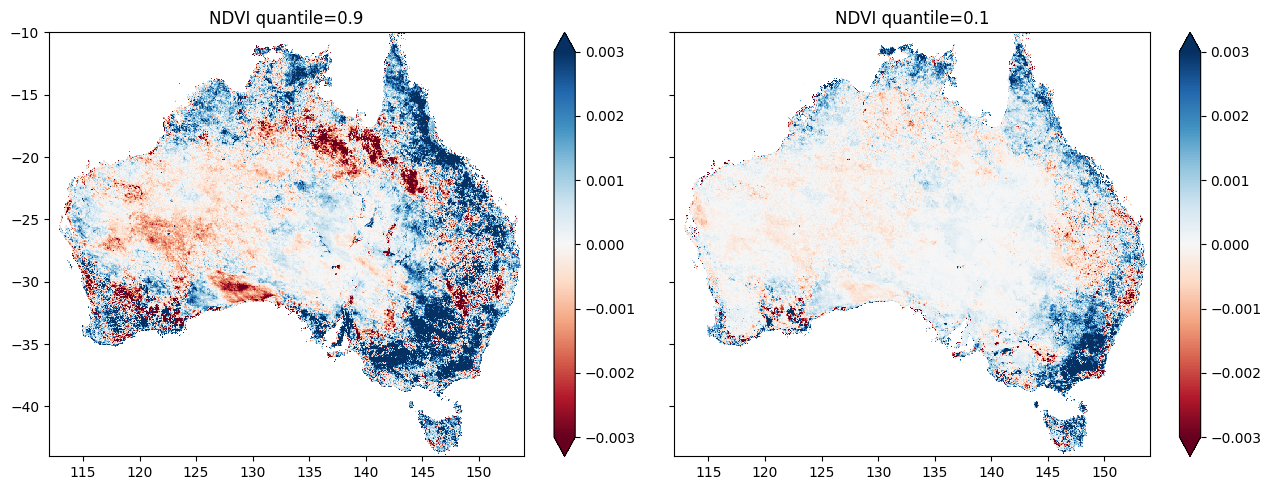

In [41]:
fig,ax = plt.subplots(1,2, figsize=(13,5), sharex=True, sharey=True)
ndvi_trend_90.slope.plot.imshow(vmax=0.003,vmin=-0.003, cmap='RdBu', ax=ax[0], add_labels=False)
ndvi_trend_10.slope.plot.imshow(vmax=0.003,vmin=-0.003, cmap='RdBu', ax=ax[1], add_labels=False)
ax[0].set_title('NDVI quantile=0.9')
ax[1].set_title('NDVI quantile=0.1')
plt.tight_layout();

### Plot

In [ ]:
# et_trend.where(er_trend.p_value < 0.1).slope.plot.imshow(cmap='RdBu', robust=True, size=10)

In [ ]:
fig,ax = plt.subplots(2,2, figsize=(14,10), sharex=True, sharey=True)

im = er_trend.slope.plot(cmap='RdBu', robust=True, ax=ax[0,0], add_colorbar=False, add_labels=False) #vmax=0.75, vmin=-0.75,
cbar = plt.colorbar(im, ax=ax[0,0], shrink=0.75)
ax[0,0].set_title('Linear trend in ER')
ctx.add_basemap(ax[0,0], source=ctx.providers.Esri.WorldImagery, crs='EPSG:4326', attribution='Esri World Imagery', attribution_size=1)

im = gpp_trend.slope.plot(cmap='RdBu', robust=True, ax=ax[0,1], add_colorbar=False, add_labels=False)
cbar = plt.colorbar(im, ax=ax[0,1], shrink=0.75)
ax[0,1].set_title('Linear trend in GPP')
ctx.add_basemap(ax[0,1], source=ctx.providers.Esri.WorldImagery, crs='EPSG:4326', attribution='Esri World Imagery', attribution_size=1)

im = et_trend.slope.plot(cmap='RdBu', robust=True, ax=ax[1,0], add_colorbar=False, add_labels=False)
cbar = plt.colorbar(im, ax=ax[1,0], shrink=0.75)
ax[1,0].set_title('Linear trend in ET')
ctx.add_basemap(ax[1,0], source=ctx.providers.Esri.WorldImagery, crs='EPSG:4326', attribution='Esri World Imagery', attribution_size=1)

im = nee_trend.slope.plot(cmap='RdBu_r', robust=True, ax=ax[1,1], add_colorbar=False, add_labels=False)
cbar = plt.colorbar(im, ax=ax[1,1], shrink=0.75)
ax[1,1].set_title('Linear trend in NEE')
ctx.add_basemap(ax[1,1], source=ctx.providers.Esri.WorldImagery, crs='EPSG:4326', attribution='Esri World Imagery', attribution_size=1)
plt.tight_layout();
plt.savefig('/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/linear_trends.png', bbox_inches='tight')

In [ ]:
ndvi_trend.slope.plot(cmap='RdBu', robust=True, size=6)
plt.title('Linear Trend in NDVI');

## Plot extent on interactive map

In [ ]:
m = folium.Map(control_scale = True)

# gpp_trend.where(gpp_trend.p_value<0.1).slope.odc.add_to(m, robust=True, cmap='RdBu')
nee_trend.slope.odc.add_to(m, robust=True, cmap='RdBu_r')

# Zoom map to Australia
m.fit_bounds(gpp_trend.odc.map_bounds())

tile = folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = True,
        control = True
       ).add_to(m)

folium.LayerControl().add_to(m)
display(m)

## Per bioclimatic region

In [ ]:
bio = assign_crs(xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.nc'), crs='EPSG:4326')
gdf = gpd.read_file('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.geojson')

In [ ]:
trends_var = [et_trend, er_trend, nee_trend, gpp_trend, wue_trend]
names = ['ET', 'ER', 'NEE', 'GPP', 'WUE', 'NDVI']

outer = []
for index, row in gdf.iterrows():
    mask = xr_rasterize(gdf.iloc[[index]], gpp.isel(time=1))
    mask = round_coords(mask)

    inner = []
    for v,n in zip(trends_var, names):
        var_region = v.where(mask).compute()
        df_var_region = var_region.slope.drop('spatial_ref').to_dataframe().reset_index(drop=True).rename({'slope':n+'_'+row['region_name']},axis=1)
        inner.append(df_var_region)
    outer.append(inner)


### Plot trend distribution per region



In [ ]:
fig,ax = plt.subplots(2,3, figsize=(15,8), sharex=True, sharey=True)
for a,i,n in zip(ax.reshape(-1), range(0,6), list(gdf.region_name.values)): 
    dff = pd.concat(outer[i])
    dff = dff.drop('WUE_'+n, axis=1)
    sb.kdeplot(dff, fill=True, ax=a)
    a.axvline(0, c='grey', linestyle='--')
    a.set_xlim(-1.0, 1.0)
    a.set_ylabel('')
fig.supylabel('Density', fontsize=15)
fig.supxlabel('Trend (2003-2021) year⁻¹', fontsize=15)
plt.tight_layout()
fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/trend_dist_bioregion.png", bbox_inches='tight')

## Disaggregate further by vegetation types using National Veg Info System

https://www.environment.gov.au/fed/catalog/search/resource/downloadData.page?uuid=ab942d6d-9efd-4cf2-bec7-4c1521b83803



In [ ]:
import rioxarray as rxr
ds = rxr.open_rasterio('/g/data/os22/chad_tmp/climate-carbon-interactions/data/aus6_0e_mvg.tif').squeeze().drop('band')

In [ ]:
woody_vals = [1,2,3,5,6,7,8,9,11,12,13,14]
grass_vals = [119,20,21]
shrubs_vals = [15,16,17,18,22,32]
crops_vals = [25]

In [ ]:
woody = ds.isin(woody_vals)
grass = ds.isin(grass_vals)
shrubs = ds.isin(shrubs_vals)
crops = ds.isin(crops_vals)

In [ ]:
woody = woody.odc.reproject(how=er.odc.geobox, resampling='mode').rename('Woodlands')
grass = grass.odc.reproject(how=er.odc.geobox, resampling='mode').rename('Grasses')
shrubs = shrubs.odc.reproject(how=er.odc.geobox, resampling='mode').rename('Shrubs')
crops = crops.odc.reproject(how=er.odc.geobox, resampling='mode').rename('Crops')

woody =  round_coords(woody)
grass =  round_coords(grass)
shrubs =  round_coords(shrubs)
crops =  round_coords(crops)

In [ ]:
fig,ax = plt.subplots(1,4, figsize=(17,4), sharex=True, sharey=True)
woody.plot.imshow(ax=ax[0], add_colorbar=False, add_labels=False)
grass.plot.imshow(ax=ax[1], add_colorbar=False, add_labels=False)
shrubs.plot.imshow(ax=ax[2], add_colorbar=False,add_labels=False)
crops.plot.imshow(ax=ax[3], add_colorbar=False, add_labels=False)
ax[0].set_title('Woody Cover')
ax[1].set_title('Grasses')
ax[2].set_title('Shrubs')
ax[3].set_title('Crops et al.')
plt.tight_layout();

### Break veg types into bioclimatic regions

In [ ]:
bioclim_masks = []
for index, row in gdf.iterrows():    
    mask = xr_rasterize(gdf.iloc[[index]], gpp.isel(time=1))
    mask = mask.rename(row['region_name'])
    bioclim_masks.append(round_coords(mask))

In [ ]:
woody_temperate = woody.where((bioclim_masks[3] | bioclim_masks[2])).astype(np.int8).rename('Woody_temperate')
woody_tropics = woody.where(bioclim_masks[0]).astype(np.int8).rename('Woody_tropics')
woody_med = woody.where(bioclim_masks[4]).astype(np.int8).rename('Woody_mediterranean')
woody_semiarid = woody.where((bioclim_masks[1] | bioclim_masks[5])).astype(np.int8).rename('Woody_(semi)arid')

crops_med = crops.where(bioclim_masks[4]).astype(np.int8).rename('Crop_mediterranean')
crops_temp = crops.where((bioclim_masks[3] | bioclim_masks[2])).astype(np.int8).rename('Crop_temperate')

grasses_semiarid = grass.where((bioclim_masks[1] | bioclim_masks[5])).astype(np.int8).rename('Grasses_(semi)arid')

shrubs_semiarid = shrubs.where((bioclim_masks[1] | bioclim_masks[5])).astype(np.int8).rename('Shrubs_(semi)arid')

In [ ]:
masks = [woody_temperate,woody_tropics,woody_med,woody_semiarid,crops_med,crops_temp, grasses_semiarid, shrubs_semiarid]

In [ ]:
fig,ax = plt.subplots(2,4, figsize=(14,6), sharex=True, sharey=True)
for a,m,n in zip(ax.reshape(-1), masks, [mask.name for mask in masks]): 
    m.where(m==1).plot(ax=a, add_colorbar=False, add_labels=False, cmap='Wistia')
    ctx.add_basemap(a, source=ctx.providers.Esri.WorldImagery, crs='EPSG:4326', attribution='', attribution_size=1)
    a.set_title(n)
plt.tight_layout();

### Extract trends for cover types

In [ ]:
trends_var = [et_trend, er_trend, nee_trend, gpp_trend, wue_trend, ndvi_trend]
names = ['ET', 'ER', 'NEE', 'GPP', 'WUE', 'NDVI']
# masks = [woody, shrubs_grass, crops]
masks = [woody_temperate,woody_tropics,woody_med,woody_semiarid,crops_med,crops_temp, grasses_semiarid, shrubs_semiarid]

outer = []
for mask in masks:    
    inner = []
    for v,n in zip(trends_var, names):
        var_region = v.where(mask).compute()
        df_var_region = var_region.slope.drop('spatial_ref').to_dataframe().reset_index(drop=True).rename({'slope':n+'_'+mask.name},axis=1)
        inner.append(df_var_region)
    outer.append(inner)


### Plot

In [ ]:
fig,ax = plt.subplots(2,4, figsize=(17,8), sharex=True, sharey=True)
for a,i,n in zip(ax.reshape(-1), range(0,8), [mask.name for mask in masks]): 
    dff = pd.concat(outer[i])
    sb.kdeplot(dff.drop(['WUE_'+n,'NDVI_'+n], axis=1), fill=True, ax=a)
    a.axvline(0, c='grey', linestyle='--')
    a.set_xlim(-1.0, 1.0)
    a.set_ylabel('')
fig.supylabel('Density', fontsize=15)
fig.supxlabel('Trend (2003-2021) year⁻¹', fontsize=15)
plt.tight_layout()
fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/trend_dist_bioregion_Veg.png", bbox_inches='tight')

### Plot WUE & NDVI

In [ ]:
fig,ax = plt.subplots(2,4, figsize=(17,8), sharex=True, sharey=True)
for a,i,n in zip(ax.reshape(-1), range(0,8), [mask.name for mask in masks]): 
    dff = pd.concat(outer[i])
    sb.kdeplot(dff['WUE_'+n], fill=True, ax=a)
    a.axvline(0, c='grey', linestyle='--')
    a.set_xlim(-0.03, 0.03)
    a.set_ylabel('')
    a.set_xlabel('')
    a.set_title(n)
fig.supylabel('Density', fontsize=15)
fig.supxlabel('Trend (2003-2021) year⁻¹', fontsize=15)
plt.tight_layout()
fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/trend_wue_dist_bioregion_veg.png", bbox_inches='tight')

In [ ]:
fig,ax = plt.subplots(2,4, figsize=(17,8), sharex=True, sharey=True)
for a,i,n in zip(ax.reshape(-1), range(0,8), [mask.name for mask in masks]): 
    dff = pd.concat(outer[i])
    sb.kdeplot(dff['NDVI_'+n], fill=True, ax=a)
    a.axvline(0, c='grey', linestyle='--')
    a.set_xlim(-0.005, 0.005)
    a.set_ylabel('')
    a.set_xlabel('')
    a.set_title(n)
fig.supylabel('Density', fontsize=15)
fig.supxlabel('Trend (2003-2021) year⁻¹', fontsize=15)
plt.tight_layout()
fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/trend_ndvi_dist_bioregion_veg.png", bbox_inches='tight')

## Disaggregate by C3/C4 grass (Donohue product)

In [ ]:
# C3 grass has been mislabelled as C4
c3_grass = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/1km/C4_grass_1km_monthly_2002_2022.nc').isel(time=1).rename('C3_grass').drop('time')
grass = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/1km/grass_1km_monthly_2002_2022.nc').isel(time=1).drop('time')
c4_grass = (grass - c3_grass).rename('C4_grass')

### Threshold

In [ ]:
grass_mask = xr.where(grass>0.5 ,1 ,0).astype(np.int8).rename('grass_mask')

In [ ]:
dominant_c3 = (xr.where(c3_grass>c4_grass, 1, 0)).where(grass_mask).astype(np.int8).rename('C3_grass')
dominant_c4 = (xr.where(c4_grass>c3_grass, 1, 0)).where(grass_mask).astype(np.int8).rename('C4_grass')

In [ ]:
masks = [grass_mask, dominant_c3, dominant_c4]

fig,ax = plt.subplots(1,3, figsize=(15,4), sharex=True, sharey=True)
for a,m,n in zip(ax.reshape(-1), masks, [mask.name for mask in masks]): 
    m.where(m==1).plot(ax=a, add_colorbar=False, add_labels=False, cmap='Wistia')
    ctx.add_basemap(a, source=ctx.providers.Esri.WorldImagery, crs='EPSG:4326', attribution='', attribution_size=1)
    a.set_title(n)
plt.tight_layout();

### Extract trends for grasses

In [ ]:
trends_var = [et_trend, er_trend, nee_trend, gpp_trend, wue_trend]
names = ['ET', 'ER', 'NEE', 'GPP', 'WUE']
masks = [grass_mask, dominant_c3, dominant_c4]

outer = []
for mask in masks:    

    inner = []
    for v,n in zip(trends_var, names):
        var_region = v.where(mask).compute()
        df_var_region = var_region.slope.drop('spatial_ref').to_dataframe().reset_index(drop=True).rename({'slope':n+'_'+mask.name},axis=1)
        inner.append(df_var_region)
    outer.append(inner)


### plot

In [ ]:
fig,ax = plt.subplots(1,3, figsize=(15,4), sharex=True, sharey=True)
for a,i,n in zip(ax.reshape(-1), range(0,3), [mask.name for mask in masks]): 
    dff = pd.concat(outer[i])
    sb.kdeplot(dff.drop('WUE_'+n, axis=1), fill=True, ax=a)
    a.axvline(0, c='grey', linestyle='--')
    a.set_xlim(-1.0, 1.0)
    a.set_ylabel('')
fig.supylabel('Density', fontsize=15)
fig.supxlabel('Trend (2003-2021) year⁻¹', fontsize=15)
plt.tight_layout()
fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/trend_dist_grasses.png", bbox_inches='tight')